In [5]:
import pandas as pd
from datetime import datetime

In [6]:
def parse(date):
    return datetime.strptime(date, '%Y %m %d %H')

In [34]:
dataset = pd.read_csv('./raw.csv', parse_dates=[['year','month','day','hour']], date_parser=parse,index_col=0)

In [35]:
dataset.drop('No', axis=1, inplace=True)

In [36]:
dataset.columns=['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']

In [37]:
dataset.index.name = 'date'

In [38]:
dataset['pollution'].fillna(0, inplace=True)

In [41]:
dataset = dataset[24:]

In [42]:
dataset.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [43]:
dataset.to_csv('pollution.csv')

In [54]:
from matplotlib import pyplot as plt

In [51]:
dataset = pd.read_csv('pollution.csv', index_col=0, header=0)

In [52]:
dataset.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [55]:
values = dataset.values

In [59]:
groups = [0,1,2,3,5,6,7]

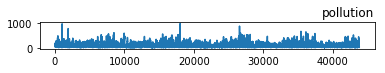

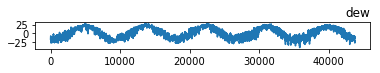

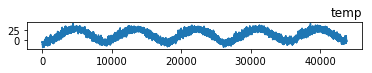

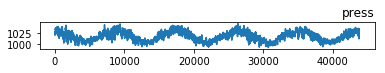

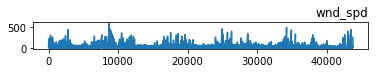

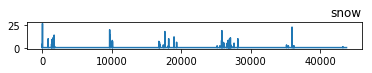

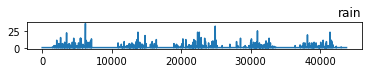

In [64]:
plt.figure()
for i, group in enumerate(groups):
    i += 1
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(dataset.columns[group], loc='right')
    plt.show()

### 将时间序列转换为有监督学习的数据集

In [87]:
def series_to_supervised(data, n_in=1, n_out=1, dropna=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)'%(j+1,i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)'%(j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)'%(j+1,i)) for j in range(n_vars)]
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropna:
        agg.dropna(inplace=True)
    return agg

### 将数据规范化

In [71]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

In [72]:
encoder = LabelEncoder()

In [73]:
values[:,4] = encoder.fit_transform(values[:,4])

In [76]:
values = values.astype('float32')

In [77]:
scaler = MinMaxScaler(feature_range=(0,1))

In [78]:
scaled = scaler.fit_transform(values)

### 转变时间序列

In [88]:
reframed = series_to_supervised(scaled)

In [91]:
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)

In [92]:
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t)
1,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893
2,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960
3,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.182093
4,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.138833
5,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.109658


### 切分数据集

In [93]:
values = reframed.values

In [94]:
n_train_hours = 365*24

In [95]:
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

In [96]:
X_train = train[:, :-1]
y_train = train[:, -1]
X_test = test[:, :-1]
y_test = test[:, -1]

In [97]:
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [99]:
print(X_train.shape,y_train.shape, X_test.shape, y_test.shape)

(8760, 1, 8) (8760,) (35039, 1, 8) (35039,)


### 搭建LSTM模型

In [100]:
import keras

E:\ANACONDA\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [103]:
from keras.layers.recurrent import LSTM
from keras.layers import Dense
from keras.models import Sequential

In [106]:
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

In [107]:
model.compile(loss='mae', optimizer='adam')

In [109]:
history = model.fit(X_train, y_train, batch_size=64, epochs=50, validation_data=(X_test,y_test), shuffle=True, verbose=2)

Train on 8760 samples, validate on 35039 samples
Epoch 1/50
 - 1s - loss: 0.0209 - val_loss: 0.0141
Epoch 2/50
 - 1s - loss: 0.0147 - val_loss: 0.0146
Epoch 3/50
 - 1s - loss: 0.0145 - val_loss: 0.0135
Epoch 4/50
 - 1s - loss: 0.0146 - val_loss: 0.0133
Epoch 5/50
 - 1s - loss: 0.0144 - val_loss: 0.0136
Epoch 6/50
 - 1s - loss: 0.0144 - val_loss: 0.0133
Epoch 7/50
 - 1s - loss: 0.0142 - val_loss: 0.0133
Epoch 8/50
 - 1s - loss: 0.0143 - val_loss: 0.0132
Epoch 9/50
 - 1s - loss: 0.0144 - val_loss: 0.0133
Epoch 10/50
 - 1s - loss: 0.0142 - val_loss: 0.0148
Epoch 11/50
 - 1s - loss: 0.0144 - val_loss: 0.0134
Epoch 12/50
 - 1s - loss: 0.0144 - val_loss: 0.0136
Epoch 13/50
 - 1s - loss: 0.0142 - val_loss: 0.0131
Epoch 14/50
 - 1s - loss: 0.0142 - val_loss: 0.0132
Epoch 15/50
 - 1s - loss: 0.0141 - val_loss: 0.0133
Epoch 16/50
 - 1s - loss: 0.0141 - val_loss: 0.0131
Epoch 17/50
 - 1s - loss: 0.0141 - val_loss: 0.0130
Epoch 18/50
 - 1s - loss: 0.0140 - val_loss: 0.0132
Epoch 19/50
 - 1s - loss

In [110]:
plt.figure()

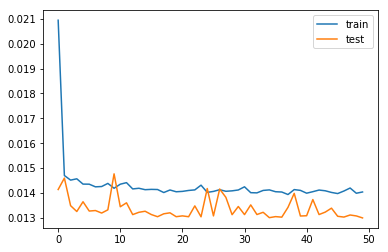

In [113]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [114]:
### 预测测试集